In [102]:
using Markdown
using InteractiveUtils
using Graphs, Random, GraphPlot, Plots, Colors, GraphRecipes
using ITensors, ITensorMPS, LinearAlgebra

In [103]:

function adj_mat_lin(N::Int)
    A = zeros(N, N)
    for i in 1:N-1
        A[i, i+1] = 1.0
        A[i+1, i] = 1.0
    end
    return A
end

function adj_mat_ent(N::Int)
    A = ones(N, N)
    A -= Matrix{Float64}(I, N, N) # Set diagonal to zero (no self-coupling)
    return A
end

adj_mat_ent (generic function with 1 method)

In [104]:
function create_MPS(L::Int, Χ::Int; conserve_qns::Bool=true)
    """Create a random MPS for a spin-1/2 chain of length L with bond dimension Χ."""
    # create a site set for a spin-1/2 chain
    sites = siteinds("S=1/2", L; conserve_qns=conserve_qns) # conserve total Sz

    # create a random MPS with bond dimension Χ
    init_state = [isodd(i) ? "Up" : "Dn" for i = 1:L] # antiferromagnetic ground state
    # THIS IS IMPORTANT - SEE NOTE BELOW
    # it sets the subspace of states we are allowed to explore
    # for example, this init_state means we only explore states with total Sz = 0 (i.e. zero magnetisation)
    # this is a reasonable assumption for positive J, but not for negative J
    # if we want to explore ferromagnetic states (negative J), we would need a different init_state
    ψ0 = randomMPS(sites, init_state)
    return ψ0, sites
end

create_MPS (generic function with 1 method)

In [105]:
function plot_adjacency_matrix(adj_mat; layout_type::String = "circular")
    """
    Plot the graph represented by the adjacency matrix.

    layout_type can be "circular", "spring", "spectral", or "random".
    """

    layout_lookup = Dict("circular" => circular_layout,
                         "spring" => spring_layout,
                         "spectral" => spectral_layout,
                         "random" => random_layout)

    G = Graphs.SimpleGraph(adj_mat)
    N = size(adj_mat, 1)

    node_labels = [string(i) for i in 1:N]

    p = GraphPlot.gplot(
        G, 
        layout=layout_lookup[layout_type],
        nodelabel=node_labels,
        nodesize=0.3,
        nodelabelsize=3,
        edgelinewidth=2.0,
    ) # plot the graph with the specified layout
    display(p)
    return p
end

plot_adjacency_matrix (generic function with 1 method)

In [106]:
function create_xxz_hamiltonian_exact(N::Int, adj_mat, J::Float64, Δ::Float64)
    """
    Constructs the exact Hamiltonian matrix for the XXZ model based on a given adjacency matrix.
    The Hamiltonian is H = J * Σ (SˣSˣ + SʸSʸ + Δ SᶻSᶻ)
    """
    # Define a shorthand for the Kronecker product
    ⊗(x, y) = kron(x, y)

    # Define Pauli matrices (using 2*S convention for σ)
    I = complex([1 0; 0 1])
    σx = complex([0 1; 1 0])
    σy = complex([0 -im; im 0])
    σz = complex([1 0; 0 -1])
    
    # Initialize Hamiltonian matrix
    dim = 2^N
    H = complex(zeros(Float64, dim, dim))

    # Construct the Hamiltonian from the adjacency matrix
    for i in 1:N-1
        for j in i+1:N
            if adj_mat[i, j] == 1.0
                # Prepare lists of identity operators
                pauli_x_ops = fill(I, N)
                pauli_y_ops = fill(I, N)
                pauli_z_ops = fill(I, N)

                # Place Pauli operators at sites i and j
                pauli_x_ops[i] = σx; pauli_x_ops[j] = σx
                pauli_y_ops[i] = σy; pauli_y_ops[j] = σy
                pauli_z_ops[i] = σz; pauli_z_ops[j] = σz

                # Build full-size operators using foldl and kron
                # Note: SˣSˣ = (1/4)σˣσˣ, so we adjust by J/4.
                H += (J / 4) * foldl(⊗, pauli_x_ops)
                H += (J / 4) * foldl(⊗, pauli_y_ops)
                H += (J * Δ / 4) * foldl(⊗, pauli_z_ops)
            end
        end
    end
    return H
end

create_xxz_hamiltonian_exact (generic function with 1 method)

In [107]:
function solve_xxz_hamiltonian_exact(H)
    eigens = eigen(Hermitian(H))
    eigenvalues = eigens.values
    ground_state = minimum(eigenvalues)
    ψ = eigens.vectors[:, argmin(eigenvalues)]
    return eigens, ground_state, ψ
end

solve_xxz_hamiltonian_exact (generic function with 1 method)

In [108]:
function create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
    ampo = OpSum()
    for i = 1:N-1
        for j = i+1:N
            if adj_mat[i, j] == 1.0  # if there is an interaction between i and j
                # SˣSˣ + SʸSʸ = 1/2 * (S⁺S⁻ + S⁻S⁺)
                ampo += (J / 2), "S+", i, "S-", j
                ampo += (J / 2), "S-", i, "S+", j
                # Δ SᶻSᶻ term
                ampo += J*Δ, "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end

create_xxz_hamiltonian_mpo (generic function with 1 method)

In [109]:
function solve_xxz_hamiltonian_dmrg(H, ψ0, sweeps::Int=10, bond_dim::Int=1000, cutoff::Float64=1E-14)
    """Solves the XXZ Hamiltonian using DMRG with given parameters. Returns the ground state energy and MPS. """
    swps = Sweeps(sweeps)
    setmaxdim!(swps, bond_dim)
    setcutoff!(swps, cutoff)
    E, ψ = dmrg(H, ψ0, swps; outputlevel=0)
    return E, ψ # only ground state and ground state wavefunction
end

solve_xxz_hamiltonian_dmrg (generic function with 4 methods)

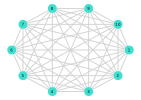

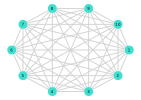

In [110]:
# parameters
N = 10 # number of nodes
Χ = 100 # bond dimension
J = 1.0 # coupling constant
Δ = 1.5 # anisotropy parameter
sweeps = 10 # number of DMRG sweeps

adj_mat = adj_mat_ent(N)
plot_adjacency_matrix(adj_mat; layout_type="circular")

# # dmrg
# ψ0, sites = create_MPS(N, Χ; conserve_qns = false)
# H_mpo = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
# dmrg_time = @elapsed E_dmrg, ψ_dmrg = solve_xxz_hamiltonian_dmrg(H_mpo, ψ0, sweeps, Χ)
# println("Ground state energy from DMRG: $E_dmrg")
# println("Time taken for DMRG: $dmrg_time seconds")

# # ED
# H_exact = create_xxz_hamiltonian_exact(N, adj_mat, J, Δ)
# exact_time = @elapsed eigens_exact, E_exact, ψ_exact = solve_xxz_hamiltonian_exact(H_exact)
# println("Ground state energy from ED:   $E_exact")
# println("Time taken for ED: $exact_time seconds")

# # --- Comparison ---
# println("\n" * repeat("-", 40))
# println("Difference between DMRG and ED energies: $(abs(E_dmrg - E_exact))")
# println(1- (abs(E_dmrg - E_exact)))

# # --- Correctly order the DMRG MPS into a vector ---
# # Default ITensor basis order is reversed compared to kron, so we must permute
# itensor_gs = ITensors.contract(ψ_dmrg)
# array_gs = array(itensor_gs)
# perm = ntuple(i -> N - i + 1, N)
# permuted_array_gs = permutedims(array_gs, perm)
# ψ_dmrg_vec = vec(permuted_array_gs)

# # Calculate the squared overlap (fidelity) between the wavefunctions
# fidelity = abs(dot(ψ_exact, ψ_dmrg_vec))^2

# println("\n" * repeat("-", 40))
# println("Fidelity (Overlap |<ψ_ED|ψ_DMRG>|²): $fidelity")
# println("Error bound from fidelity (1 - F): $(1 - fidelity)")
# println(repeat("-", 40))

In [111]:
function get_errors(N_max::Int, Χ::Int, J::Float64, Δ::Float64, sweeps::Int)

    N_values = collect(2:N_max)
    errors = Float64[]


    for N in 2:N_max
        try
            adj_mat = adj_mat_ent(N)


            # dmrg
            ψ0, sites = create_MPS(N, Χ; conserve_qns = false)
            H_mpo = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
            E_dmrg, ψ_dmrg = solve_xxz_hamiltonian_dmrg(H_mpo, ψ0, sweeps, Χ)

            # ED
            H_exact = create_xxz_hamiltonian_exact(N, adj_mat, J, Δ)
            eigens_exact, E_exact, ψ_exact = solve_xxz_hamiltonian_exact(H_exact)
            
            error = (abs(E_dmrg - E_exact))
            push!(errors, error)

            println("N = $N, Error = $error")

        catch e
            println("An error occurred at N = $N: $e")
            break 
        end
    end

    return N_values, errors
end

get_errors (generic function with 1 method)

In [112]:
function mps_to_vector(psi_mps::MPS)
    N = length(psi_mps)
    psi_tensor = ITensors.contract(psi_mps)
    psi_array = array(psi_tensor)
    permutation = ntuple(i -> N - i + 1, N)
    psi_array_ordered = permutedims(psi_array, permutation)
    
    return vec(psi_array_ordered)
end

mps_to_vector (generic function with 1 method)

In [113]:
function get_overlap(N_max::Int, Χ::Int, J::Float64, Δ::Float64, sweeps::Int)

    N_values = collect(2:N_max)
    overlaps = Float64[]


    for N in 2:N_max
        try
            adj_mat = adj_mat_ent(N)


            # dmrg
            ψ0, sites = create_MPS(N, Χ; conserve_qns = false)
            H_mpo = create_xxz_hamiltonian_mpo(N, adj_mat, J, Δ, sites)
            E_dmrg, ψ_dmrg = solve_xxz_hamiltonian_dmrg(H_mpo, ψ0, sweeps, Χ)

            ψ_dmrg_vec = mps_to_vector(ψ_dmrg)

            # ED
            H_exact = create_xxz_hamiltonian_exact(N, adj_mat, J, Δ)
            eigens_exact, E_exact, ψ_exact = solve_xxz_hamiltonian_exact(H_exact)
            
            overlap = 1 - abs(dot(ψ_dmrg_vec, ψ_exact))^2
            push!(overlaps, overlap)

            println("N = $N, overlap = $overlap")

        catch e
            println("An error occurred at N = $N: $e")
            break 
        end
    end

    return N_values, overlaps
end

get_overlap (generic function with 1 method)

In [114]:

N = 10        # Number of nodes
Χ = 100      # Bond dimension
J = 1.0      # Coupling constant
Δ = 1.5      # Anisotropy parameter
sweeps = 10  # Number of DMRG sweeps

# N_values, errors = get_errors(N, Χ, J, Δ, sweeps);

# min_error = minimum(errors)
# max_error = maximum(errors)

# normalised_errors = if max_error > min_error
#     [(err - min_error) / (max_error - min_error) for err in errors]
# else
#     zeros(length(errors))
# end


N_values, overlaps = get_overlap(N, Χ, J, Δ, sweeps)

N = 2, overlap = 0.0
N = 3, overlap = 0.75
N = 4, overlap = 0.0
N = 5, overlap = 0.19095523254879665
N = 6, overlap = 0.9342321394542002
N = 7, overlap = 0.9985177263799183
N = 8, overlap = 0.9879984131528013
N = 9, overlap = 0.9928069748732418
N = 10, overlap = 0.9550091060238516


([2, 3, 4, 5, 6, 7, 8, 9, 10], [0.0, 0.75, 0.0, 0.19095523254879665, 0.9342321394542002, 0.9985177263799183, 0.9879984131528013, 0.9928069748732418, 0.9550091060238516])

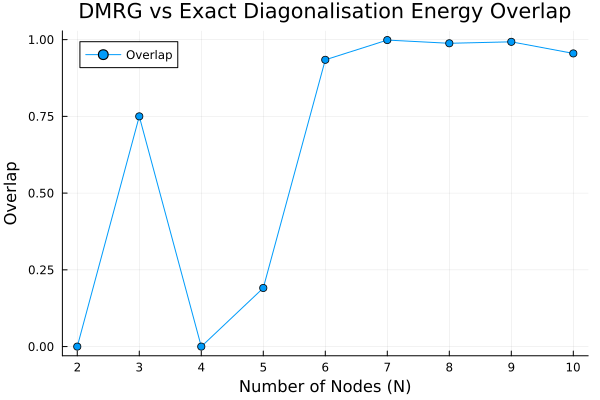

In [115]:
# display(plot(N_values, errors,
#     title="DMRG vs Exact Diagonalisation Energy Error",
#     xlabel="Number of Nodes (N)",
#     ylabel="Absolute Error",
#     label="Error",
#     marker=:circle,
#     legend=:topleft,
#     xticks=1:N
# ))

# display(plot(N_values, normalised_errors,
#     title="DMRG vs Exact Diagonalisation Energy Error",
#     xlabel="Number of Nodes (N)",
#     ylabel="Absolute Error",
#     label="Error",
#     marker=:circle,
#     legend=:topleft,
#     xticks=1:N
# ))

display(plot(N_values, overlaps,
    title="DMRG vs Exact Diagonalisation Energy Overlap",
    xlabel="Number of Nodes (N)",
    ylabel="Overlap",
    label="Overlap",
    marker=:circle,
    legend=:topleft,
    xticks=1:N
))


Calculating for Δ = 0.0
N = 2, overlap = 0.0
N = 3, overlap = 0.75
N = 4, overlap = 4.440892098500626e-16
N = 5, overlap = 0.7259347329027438
N = 6, overlap = 0.999786658971505
N = 7, overlap = 0.9733998642725645
N = 8, overlap = 0.8998997143354485
N = 9, overlap = 0.9999983086508342
N = 10, overlap = 0.9583990597404688
\nCalculating for Δ = 0.1
N = 2, overlap = 0.0
N = 3, overlap = 0.75
N = 4, overlap = 4.440892098500626e-16
N = 5, overlap = 0.6282065203362592
N = 6, overlap = 0.7161577305186565
N = 7, overlap = 0.9167705597659493
N = 8, overlap = 0.9922098962851985
N = 9, overlap = 0.9996518597309169
N = 10, overlap = 0.9174689882809676
\nCalculating for Δ = 0.3
N = 2, overlap = 0.0
N = 3, overlap = 0.75
N = 4, overlap = 4.440892098500626e-16
N = 5, overlap = 0.9183235360988311
N = 6, overlap = 0.9980574162337139
N = 7, overlap = 0.9661973642353311
N = 8, overlap = 0.8361811378905385
N = 9, overlap = 0.9899626442466491
N = 10, overlap = 0.9983163003142717
\nCalculating for Δ = 0.5
N 

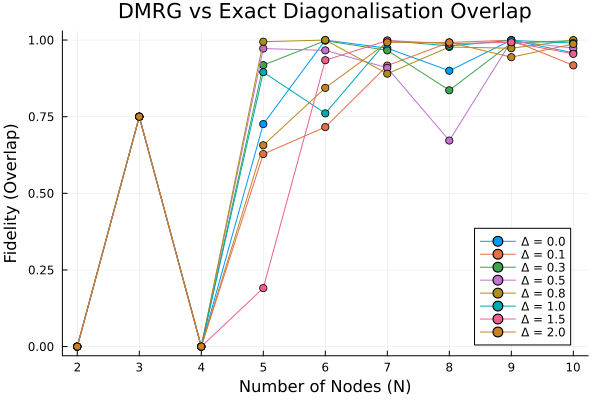

In [118]:
delta_values = [0.0, 0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0] 
N = 10
Χ = 100
J = 1.0
sweeps = 10

println("Calculating for Δ = $(delta_values[1])")
N_values, first_overlaps = get_overlap(N, Χ, J, delta_values[1], sweeps)

p = plot(N_values, first_overlaps,
    title="DMRG vs Exact Diagonalisation Overlap",
    xlabel="Number of Nodes (N)",
    ylabel="Fidelity (Overlap)",
    label="Δ = $(delta_values[1])", 
    marker=:circle,
    legend=:bottomright,
    xticks=2:N
)

for i in 2:length(delta_values)
    current_delta = delta_values[i]
    println("\\nCalculating for Δ = $current_delta")
    
    N_values, current_overlaps = get_overlap(N, Χ, J, current_delta, sweeps)
    
    plot!(p, N_values, current_overlaps, 
        label="Δ = $current_delta", 
        marker=:circle
    )
end

display(p)

